# Import Library

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random


import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from zipfile import ZipFile 

from PIL import Image

import keras

# importing libraries for Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from sklearn.model_selection import GridSearchCV
from keras.models import load_model

from keras.models import model_from_json
from keras.wrappers.scikit_learn import KerasClassifier

import PIL
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


# Prepare Traning Data

In [2]:
filenames = os.listdir("C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if 'underpass' in category:
        categories.append(str(1))
    else:
        categories.append(str(0))

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,underpass1001.jpg,1
1,underpass1002.jpg,1
2,underpass1003.jpg,1
3,underpass1004.jpg,1
4,underpass1005.jpg,1


### See Total In count

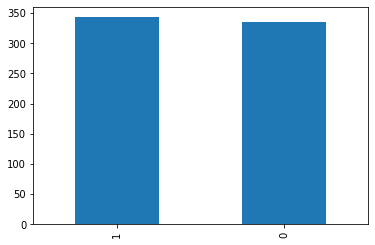

In [3]:
df['category'].value_counts().plot.bar()

# See sample image

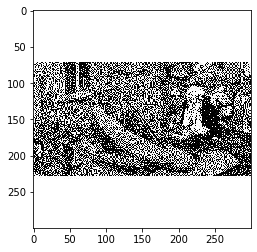

In [4]:
sample = random.choice(filenames)
image = load_img("C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/train/train/"+sample)
plt.imshow(image)

In [5]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

# Build Model

In [6]:

image_size = 75
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 32

In [7]:



pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(32, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
______________________________

# Prepare Test and Train Data

In [8]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

# Traning Generator

In [9]:
train_datagen = ImageDataGenerator(

    rescale=1.0/255.0,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 610 validated image filenames belonging to 2 classes.


# Validation Generator

In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 68 validated image filenames belonging to 2 classes.


# See sample generated images

Found 1 validated image filenames belonging to 1 classes.


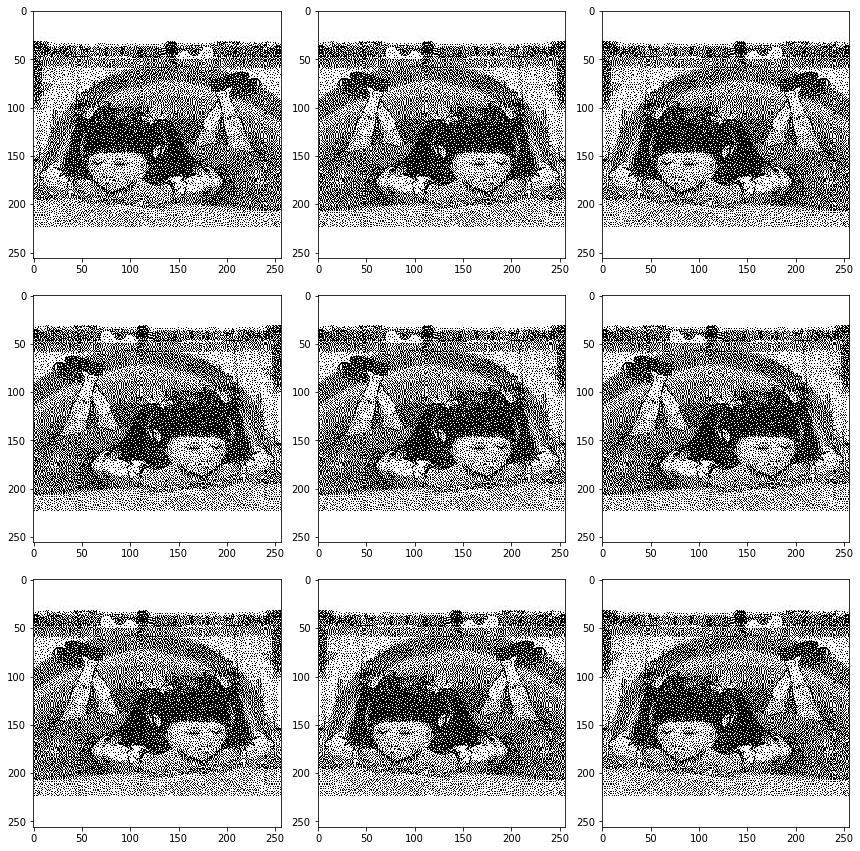

In [11]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/train/train", 
    x_col='filename',
    y_col='category',
    
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model

In [12]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)


Epoch 1/100
19/19 [==============================] - 16s 844ms/step - loss: 0.7832 - accuracy: 0.5104 - val_loss: 0.6925 - val_accuracy: 0.5312
Epoch 2/100
19/19 [==============================] - 16s 822ms/step - loss: 0.7667 - accuracy: 0.5121 - val_loss: 0.6696 - val_accuracy: 0.5278
Epoch 3/100
19/19 [==============================] - 19s 984ms/step - loss: 0.7139 - accuracy: 0.5484 - val_loss: 0.5878 - val_accuracy: 0.6667
Epoch 4/100
19/19 [==============================] - 19s 994ms/step - loss: 0.6647 - accuracy: 0.6021 - val_loss: 0.6067 - val_accuracy: 0.6406
Epoch 5/100
19/19 [==============================] - 17s 908ms/step - loss: 0.6235 - accuracy: 0.6609 - val_loss: 0.6337 - val_accuracy: 0.5278
Epoch 6/100
19/19 [==============================] - 18s 951ms/step - loss: 0.6537 - accuracy: 0.6419 - val_loss: 0.7062 - val_accuracy: 0.5556
Epoch 7/100
19/19 [==============================] - 17s 902ms/step - loss: 0.6321 - accuracy: 0.6592 - val_loss: 0.5882 - val_accuracy

Epoch 57/100
19/19 [==============================] - 37s 2s/step - loss: 0.3258 - accuracy: 0.8581 - val_loss: 0.6239 - val_accuracy: 0.7500
Epoch 58/100
19/19 [==============================] - 38s 2s/step - loss: 0.3116 - accuracy: 0.8737 - val_loss: 0.4204 - val_accuracy: 0.7656
Epoch 59/100
19/19 [==============================] - 37s 2s/step - loss: 0.3279 - accuracy: 0.8702 - val_loss: 0.4632 - val_accuracy: 0.7778
Epoch 60/100
19/19 [==============================] - 37s 2s/step - loss: 0.3479 - accuracy: 0.8720 - val_loss: 0.6283 - val_accuracy: 0.8889
Epoch 61/100
19/19 [==============================] - 38s 2s/step - loss: 0.3003 - accuracy: 0.8754 - val_loss: 0.3646 - val_accuracy: 0.7812
Epoch 62/100
19/19 [==============================] - 37s 2s/step - loss: 0.2944 - accuracy: 0.8824 - val_loss: 0.4451 - val_accuracy: 0.7500
Epoch 63/100
19/19 [==============================] - 37s 2s/step - loss: 0.3126 - accuracy: 0.8824 - val_loss: 0.2271 - val_accuracy: 0.8611
Epoch 

In [ ]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [ ]:
Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

In [ ]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [ ]:
y_final.size

In [ ]:
image_file = Image.open('C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/more test/wall2.png') # open colour image
image_file = image_file.convert('1') # convert image to black and white
image_file.save('C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/blacknwhite/1test.jpg')
test_image = image.load_img('C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/blacknwhite/1test.jpg', target_size = (250, 250))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
model.predict(x = test_image)

In [ ]:
# testing the model
def testing_image(image_directory):

    test_image = image.load_img(image_directory, target_size = (75, 75))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(x = test_image)
    print(result)
    if result[0]  >= 0.5:
        prediction = 'underpass'
    else:
        prediction = 'wall'
    return prediction

In [ ]:
direc = 'C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/more test'


for i in os.listdir(direc):

    image_file = Image.open(direc + '/' + i) # open colour image
    image_file = image_file.convert('1') # convert image to black and white
    image_file.save('C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/blacknwhite/' + i)

In [ ]:
from keras.preprocessing import image

for im in os.listdir(direc):
    
    #print('C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/blacknwhite/' + im)

    preds = testing_image('C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/blacknwhite/' + im)
    print("Prediction of the image named {} is {}.".format(im,preds))

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['0','1'])

print(report)

# Prepare Testing Data

In [24]:
test_filenames = os.listdir("C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/train/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
print
test_df['filename']

0      underpass1007.jpg
1      underpass1008.jpg
2      underpass1009.jpg
3      underpass1010.jpg
4      underpass1011.jpg
             ...        
129        wall10066.jpg
130        wall10067.jpg
131        wall10068.jpg
132        wall10069.jpg
133        wall10070.jpg
Name: filename, Length: 134, dtype: object

# Create Testing Generator

In [25]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/train/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 134 validated image filenames.


# Predict

In [26]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

NameError: name 'model' is not defined

# See predicted result

In [ ]:
sample_test = test_df.sample(n=49).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("C:/Users/asa_f/Desktop/SJSU/257/Project/Final Data/Final Data/train/test/"+filename, target_size=(256, 256))
    plt.subplot(7, 7, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

# Submission

In [35]:
import seaborn as sns

submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_13010030.csv', index=False)

plt.figure(figsize=(10,5))
sns.countplot(submission_df['label'])
plt.title("(Test data)")

KeyError: 'category'

In [ ]:
model.save('vgg16.h5')

In [ ]:
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("vgg16_model_num.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("vgg16_model_num.h5")

# Load


In [27]:
from keras.models import model_from_json
from keras.models import load_model
import keras
import tensorflow as tf 


In [28]:
loaded_model = tf.keras.models.load_model('vgg16.h5')

In [29]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0   

In [30]:
loaded_model.load_weights('vgg16_model_num.h5')

In [33]:
history = loaded_model.fit_generator(
    train_generator,
    epochs=1,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

19/19 [==============================] - 15s 765ms/step - loss: 0.2446 - acc: 0.9031 - val_loss: 0.1448 - val_acc: 0.9375


In [34]:
loss, accuracy = loaded_model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.937500  ;  loss = 0.144809 
